# Business Understanding
The task is to predict the survival on the Titanic based on the dataset of the onboard passengers of the historical journey embarked on April 15, 1912. The features include Gender, Age, Passenger class, Ticket Fare, Port of Embarkation, Family, etc. It requires a binary classification of 1/0, 1 meaning Survived and 0 meaning not survived. The input dataset has been split into training and testing sets which are available to the public through Kaggle. The output requirement is a CSV file with 2 columns - PassengerID and Survival prediction (1/0).

# Data Understanding
The Dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data.
The values are in the units of liters per capita per day, and there are 79 observations. <br>
**Download the dataset here** 
https://drive.google.com/open?id=1axM3gfGxQq4T0wuwP51DVMQAecVFmpxL
<br>
**Then answer the question**
1. Load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv).
2. Create summary of the dataset, with python function.
3. Create A line plot of a time series dataset, it will provide a lot of insight into the problem.
4. Group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.
5. Create models using ARIMA
    - Split the dataset into train and test sets directly
    The first 50% of the dataset will be held back to train the model.
    - The remaining 50% of the dataset will be iterated and test the model.
    - The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.
    - Use an ARIMA(0,1,0) on the raw data may be a good starting point.
    - When model trained, a one-step prediction made ang the prediction stored for later evaluation.
    - The actual observation from the test dataset woll be added to the training dataset for the next iteration.
    - The predictions made during the enumeration of the test dataset will be evaluated and an RMSE score reported.
6. Calculate the RMSE using the helper function from the scikit-learn library, from dataset only
    - Those RMSE will show you on average, how much the error/the model was wrong/gap between predection and expected value per capita per day for each prediction made.

#### *1. Load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv).*

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import labelencoder
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

#import pacf/acf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller

#import arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [2]:
df =  pd.read_csv('water.csv', error_bad_lines=False)
df.head()

b'Skipping line 82: expected 2 fields, saw 3\n'


,Year,"Baltmore city annual water use, liters per capita per day, 1885-1968"
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413


In [3]:
df.shape

(79, 2)

We know that this dataset (Annual Water Usage in Baltimore) contain 79 rows and 2 column

In [0]:
# rename colums Baltmore city annual water use, liters per capita per day, 1885-1968 as Year
df = df.rename(columns={'Baltmore city annual water use, liters per capita per day, 1885-1968': 'water'})
df.water = df.water.astype('float64')

In [5]:
# set year as a index used to analyzed in time series analysis
df = df.set_index('Year')
df.head()

,water
Year,
1885,356.0
1886,386.0
1887,397.0
1888,397.0
1889,413.0


In [6]:
# state dataset 69 row 
split_point = len(df) - 10
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', index=False)
validation.to_csv('validation.csv', index=False)

Dataset 69, Validation 10


#### *2. Create summary of the dataset, with python function.*

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 1885 to 1963
Data columns (total 1 columns):
water    79 non-null float64
dtypes: float64(1)
memory usage: 1.2 KB


all the types of data is float64

In [8]:
df.describe()

,water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


In [9]:
X_train, X_validation = train_test_split(df, test_size=0.33, shuffle=False)
len(X_train), len(X_validation)

(52, 27)

#### *3. Create A line plot of a time series dataset, it will provide a lot of insight into the problem.*

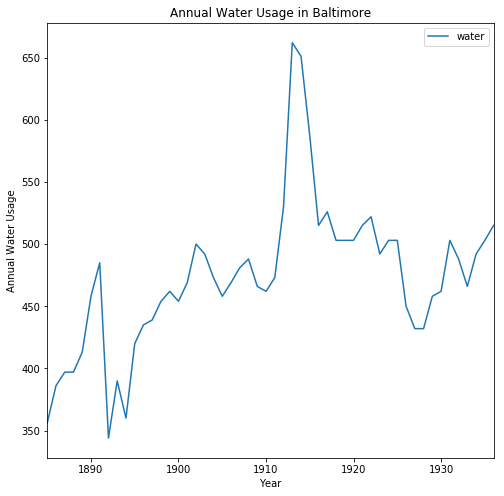

In [10]:
# create line plot from dataset.csv or train data
X_train.plot(figsize=(8,8))
plt.xlabel('Year')
plt.ylabel('Annual Water Usage')
plt.title('Annual Water Usage in Baltimore')
plt.show()

Based on the **line plot**, we can know that:
1. Annual water usage in Baltimore is fluctuative and the trend tends to increase
2. At some moment the water usage is dropped dramatically, and
3. At some moment the water usage is rose dramatically. <br>

Then can do **Rolling Statistics**. Because, it can be seen that the plot of rolling mean and rolling std is in a straight line (it does not have a specific pattern or pattern). So it can be said that the feature water use is stationary in the range/variance and mean/mean of the annual water usage.

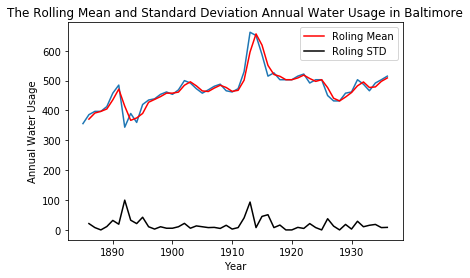

In [11]:
rolmean = X_train.rolling(window=2).mean()
rolstd = X_train.rolling(window=2).std()
plt.plot(X_train)
plt.plot(rolmean,color='red',label='Roling Mean')
plt.plot(rolstd,color='black',label='Roling STD')
plt.xlabel('Year')
plt.ylabel('Annual Water Usage')
plt.title('The Rolling Mean and Standard Deviation Annual Water Usage in Baltimore')
plt.legend(loc='best')
plt.show()

Based on the visualization, we can know the calculate of rolling mean and standard deviation on annual water usage in a year. There is no significance difference between the result of rolling mean and rolling standard deviation.

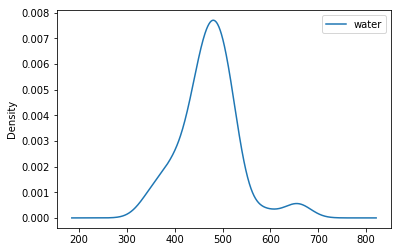

In [12]:
# subplot graph
X_train.plot(kind='kde')

Based on the subplot, the distribution is not Gaussian, but close to.

#### *4. Group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.*

In [13]:
# check min and max year
dfdecade =  pd.read_csv('water.csv', error_bad_lines=False)
dfdecade = dfdecade.rename(columns={'Baltmore city annual water use, liters per capita per day, 1885-1968': 'water'})
dfdecade.water = dfdecade.water.astype('float64')
dfdecade['Year'].min()

b'Skipping line 82: expected 2 fields, saw 3\n'


1885

In [14]:
dfdecade['Year'].max()

1963

In [0]:
labels=["{0} - {1}".format(i, i+9) for i in range(1885, 1960, 10)]
dfdecade['Decade']=pd.cut(dfdecade.Year, range(1885, 1968, 10), right=False, labels=labels)

In [16]:
dfdecade.head()

,Year,water,Decade
0,1885,356.0,1885 - 1894
1,1886,386.0,1885 - 1894
2,1887,397.0,1885 - 1894
3,1888,397.0,1885 - 1894
4,1889,413.0,1885 - 1894


#### *5. Create models using ARIMA*

#### PACF/ACF
By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed. You are already familiar with the ACF plot: it is merely a bar chart of the coefficients of correlation between a time series and lags of itself. The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

In [17]:
print('Dickey-fuller test')
dftest = adfuller(X_train['water'],autolag='AIC')
print(dftest)
dfoutput=pd.Series(dftest[0:4],index=['Test Stat','p-value','lag_used','number of obs used'])
dfoutput

Dickey-fuller test
(-2.7421004965362523, 0.06703204860767971, 1, 50, {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}, 384.2395531843111)


Test Stat             -2.742100
p-value                0.067032
lag_used               1.000000
number of obs used    50.000000
dtype: float64

**The Dickey–Fuller test** tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

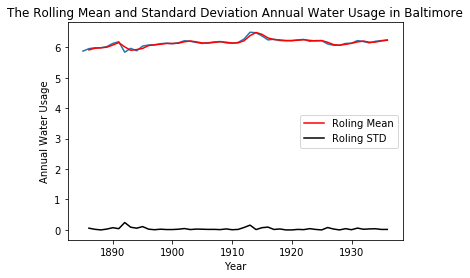

In [18]:
X_train2 = np.log(X_train)
rolmean = X_train2.rolling(window=2).mean()
rolstd = X_train2.rolling(window=2).std()
plt.plot(X_train2)
plt.plot(rolmean,color='red',label='Roling Mean')
plt.plot(rolstd,color='black',label='Roling STD')
plt.xlabel('Year')
plt.ylabel('Annual Water Usage')
plt.title('The Rolling Mean and Standard Deviation Annual Water Usage in Baltimore')
plt.legend(loc='best')
plt.show()

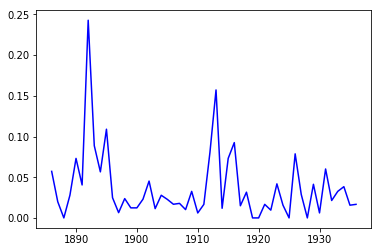

In [19]:
plt.plot(rolstd,color='blue',label='Rolling Standard Deviation')

In [20]:
print('Dickey-fuller test')
diff = X_train['water'] - X_train['water'].shift()
diff = diff.dropna()
dftest = adfuller(diff,autolag='AIC')
print(dftest)
dfoutput = pd.Series(dftest[0:4],index=['Test Stat','p-value','lag_used','number of obs used'])
dfoutput

Dickey-fuller test
(-5.27370010615997, 6.20599989595577e-06, 1, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 381.5868098955805)


Test Stat             -5.273700
p-value                0.000006
lag_used               1.000000
number of obs used    49.000000
dtype: float64

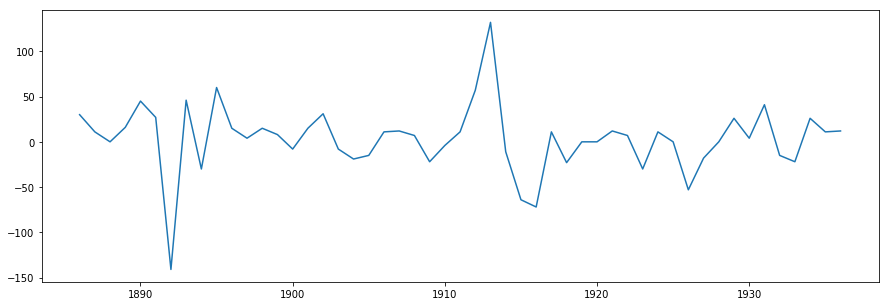

In [21]:
plt.figure(figsize=(15,5))
plt.plot(diff)

### GRAPH OF PACF/ACF

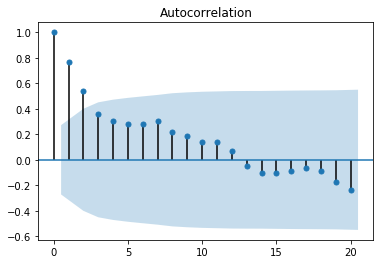

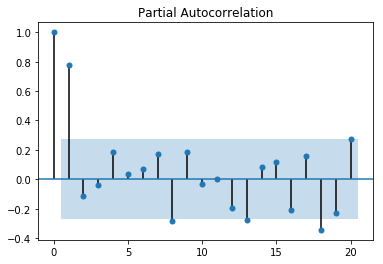

In [22]:
import statsmodels.graphics.tsaplots as sts
sts.plot_acf(X_train, lags=20)
sts.plot_pacf(X_train, lags=20)
plt.show()